## Bibliotecas

In [36]:
import pandas as pd
import plotly_express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind,mannwhitneyu

## EDA

In [37]:
data = pd.read_csv('./creditcard.csv')

### Analisando frequência das classe

In [ ]:
data['Class'].value_counts(100)
# ~99,8% para não fraudes
# ~0,2% para fraudes

### Limpeza dos Dados/Verificação de Valores Nulos ou Duplicados

In [ ]:
# Verificando se há valores nulos
data.isna().sum()

#Verificando se há valores duplicados
# Cerca de 1081 linhas de dados duplicados
data[data.duplicated()]


# Cerca 19 dados fraudulentos estão duplicados...
data[(data.duplicated())&(data['Class']==1)]
# Iremos dropa-los a fim de evitar possível sobreajuste do modelo...
data = data.drop_duplicates()

#Verificando após o drop de linhas duplicadas como ficou a proporção da nossas Classes
data['Class'].value_counts(100)
# A proporção da classe de fraudes diminui cerca de quase 0,00005%

### Analisando a estatística descritivas de todo Data set e Fraudes/Não Fraudes


In [ ]:
df_fraud = data[data['Class']==1]
df_not_fraud = data[data['Class']==0]

display('All data',data.describe())
display('Fraude',df_fraud.describe())
display('Nao Fraude',df_not_fraud.describe())

#OBSERVAÇÕES:
#Médias e Medianas entre Fraudes e Não Fraudes se diferem em algumas variáveis
#Alta presença de outliers
#Algumas distribuições são assimétricas

### Outliers

In [ ]:
# Verificação de outliers com boxplot
ncols = 3
nrows = int(np.ceil(len(data.columns) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,45))

# Criando boxplots para cada coluna
for i, column in enumerate(data.columns): #retirando Class
    ax = axes.flatten()[i]  # Obtendo o eixo atual
    sns.boxplot(x="Class", y=column, data=data, ax=ax)  
    ax.set_title(column)  # Adicionando título

# Ajustando layout
plt.tight_layout()
plt.show()

#OBSERVAÇÕES:
# Pela plotagem do Gráfico vemos uma grande quantide de outliers que podem atrapalhar a generalização do modelo...
# Iremos verificar se é possível dropar os outliers sem afetar significativamente os dados.


In [ ]:
# Cálculo do Inter Quartile Range ( IQR )

def Calculo_IQR(df,column):
    #1 quartil
    Q1 = np.percentile(df[column],25)
    #3 quartil
    Q3 = np.percentile(df[column],75)
    #IQR
    IQR = Q3 - Q1
    #Outlier Gap
    outlier_gap = 1.5 * IQR
    #List of outliers
    outlier_list_index = df[(df[column] < Q1 - outlier_gap) | (df[column] > Q3 + outlier_gap)].index
    return outlier_list_index

# Checking Outliers
lista_outliers_index = []
for column in data.columns[:-1]:
    lista_outlier = Calculo_IQR(data,column) 
    lista_outliers_index.extend(lista_outlier)    
    print(f'Ouliers na coluna {column} é de {len(lista_outlier)}')

In [ ]:
#Retirando index duplicados ( é possível outlier de V2 tenha mesma index do V3 por exemplo )
lista_outliers_index = list(set(lista_outliers_index))

#Gerando DataSet de Outliers
data_outlier = data.loc[lista_outliers_index,:]

#Verificando Quantidade de Classes
data_outlier['Class'].value_counts()

#OBSERVAÇÕES:

# Base de dados de Outlier tem cerca de 458/473 das classes fradulentas...
# Devido a grande perda de dados, não iremos remover os outliers.
# Uma alternativa é utilização de modelos/técnicas que consigam lidar bem com os outliers.

### Verificando Distribuições das variáveis

In [ ]:
# Podemos ver quais variáveis independentes possuem distribuições diferentes dada a classe (Fraude ou Não Fraude)
# Queremos sempre que haja distintas distribuições, dessa maneira é mais fácil do modelo captar os padrões

colunas = data.columns[1:-2]
ncols = 3
nrows = int(np.ceil(len(colunas) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,45))

# Criando boxplots para cada coluna
for i, column in enumerate(colunas): #retirando Class
    ax = axes.flatten()[i]  # Obtendo o eixo atual
    sns.histplot(data[data['Class'] == 1][column], kde=True, color='red', label='Fraude', stat='density', ax=ax)
    sns.histplot(data[data['Class'] == 0][column], kde=True, color='blue', label='Não Fraude', stat='density', ax=ax)
    ax.set_title(column)  # Adicionando título
    ax.set(xlabel='')  # Removendo rótulo do eixo x
# Removendo subplots extras
for j in range(len(colunas), ncols * nrows):
    fig.delaxes(axes.flatten()[j])

# Ajustando layout
plt.tight_layout()
plt.show()

#OBSERVAÇÕES:
# Variáveis que parecem distribuição bem diferente: V3, V4, V7, V9, V10, V11, V12, V14, V16
# Variáveis que parecem distribuição pouco diferente: V2, V1, V5, V6, V8, V17, V18, V19, V21
# Variáveis que parecem distribuição nada diferente:   V13, V15, V20, V22, V23, V24, V25, V26, V27, V28

In [ ]:
# Outra maneira de fazer verificação é utilizando T-Test e U-test

#T-test


# Nivel de significância
alpha_1 = 0.05 #95%
alpha_2 = 0.01 #99%

# Colunas das variáveis PCA:
pca_columns = [x for x in data.columns if 'V' in x]

#Lista para DataFrame
results = []

for feature in pca_columns:
    t_statistic, p_value = ttest_ind(df_fraud[feature], df_not_fraud[feature],equal_var=False)
    rejeita_h0_alpha1 = p_value < alpha_1
    rejeita_h0_alpha2 = p_value < alpha_2
    results.append({
        'Feature': feature,
        'Test Statistic':t_statistic,
        'P-value': p_value,
        'Nivel de Significância_1': alpha_1,
        'Rejeita H0_1': rejeita_h0_alpha1,
        'Nivel de Significância_2': alpha_2,
        'Rejeita H0_2': rejeita_h0_alpha2,
    })
results_df = pd.DataFrame(results)
print('T-test')
display(results_df)
print('==========================//=======================//====================')
#U-test
#Ho não há diferenças significativas entre distribuições da amostra
#h1 há diferenças significativas entre distribuições da amostra
# Nivel de significância
alpha_1 = 0.05 #95%
alpha_2 = 0.01 #99%

# Colunas das variáveis PCA:
pca_columns = [x for x in data.columns if 'V' in x]

#Lista para DataFrame
results = []

for feature in pca_columns:
    t_statistic, p_value = mannwhitneyu(df_fraud[feature], df_not_fraud[feature])
    rejeita_h0_alpha1 = p_value < alpha_1
    rejeita_h0_alpha2 = p_value < alpha_2
    results.append({
        'Feature': feature,
        'Test Mann-Whitney':t_statistic,
        'P-value': round(p_value,4),
        'Nivel de Significância_1': alpha_1,
        'Rejeita H0_1': rejeita_h0_alpha1,
        'Nivel de Significância_2': alpha_2,
        'Rejeita H0_2': rejeita_h0_alpha2,
    })
results_df = pd.DataFrame(results)
print('U-test')
display(results_df)


#OBSERVAÇÕES:
# Nota-se que o T-Test indicou que as variáveis: V13, V15, V22, V23, V25, V26 possuem distribuições iguais 
# Nota-se que o U-Test indicou que as variáveis: V13, V15, V22 e V25
# Sugere-se que retire essas variáveis uma vez que elas possivelmente não irão ajudar na predição do nosso modelo

### Verificando as Correlações

In [ ]:
# Nosso objetivo é captar e classificar corretamente as classes de fraudes.
# Então será analisado como as features se correlacionam com nosso target.

# Calcular a matriz de correlação
correlation_matrix = data.corr()

# Criar um mapa de calor
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor de Correlação')
plt.show()

In [ ]:

# Eu não quero features que possuam nenhuma correlação com nossa variável Alvo.
# No processo de feature selection analisando as distribuições a gente retirou as variáveis:
# V13, V15, V22, V23, V25, V26
# Nota-se que a correlação dessa variáveis com a Class são de respectivamente de:
# V22       0.004887
# V26       0.004265
# V25       0.003202
# V15      -0.003300
# V13      -0.003897
# V23      -0.006333
# V24      -0.007210
pd.set_option('display.max_rows',31)
df_corr = correlation_matrix['Class'].sort_values(ascending=False)
display(df_corr)
# Diante disso, iremos de fato retirar essa variáveis do modelo e fazer testes para verificar se há diferença nos
# resultados.

### Time e Amount

#### Time

In [ ]:
# Iremos explorar as únicas variáveis que é de fato conhecida no dataset: Tempo e Valor de Transação

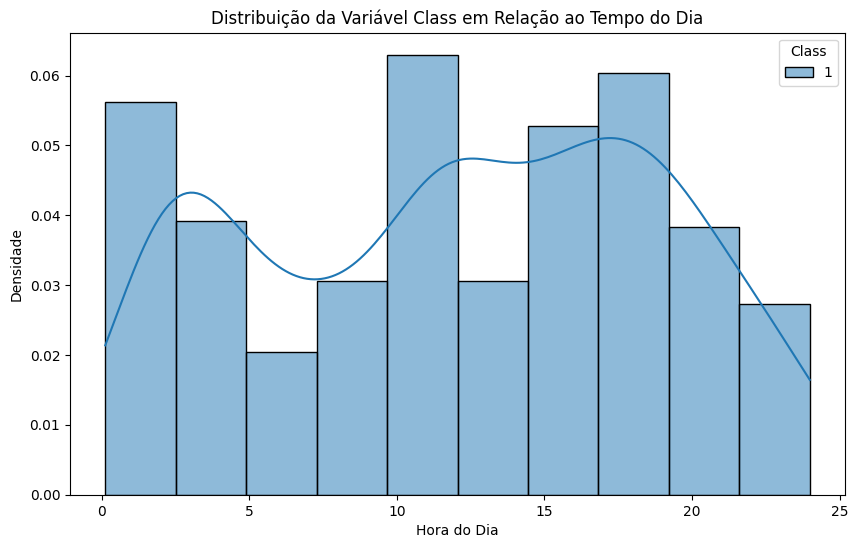

In [85]:
# Primeiro iremos plotar gráfico de dispersão da variável Time
# "Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset."
# Basicamente feature Time é diferença de tempos em segundos a partir da primeira transação.
# Podemos então transformar essa feature em Horas/Dias e verificar se há algum padrão de horário para as
# transações fraudulentas

#Transformando em hora:
data['Time_hr'] = data['Time']/3600
#Nota-se que é uma base de dados de 2 dias transações (Ultimo dado tem 48hrs).
# Iremos supor que as transações começaram a ser contabilizadas as Meia noite de t e foram até meia noite de t+2

# Os dados que contém 24hrs+ horas serão diminuidos -24, assim teremos horário certo de cada transação.
data['Time_hr'] = np.where(data['Time_hr'] > 24, data['Time_hr'] - 24, data['Time_hr'])

# Agora podemos ver se há algum padrão de horário para transações fraudulentas
teste = data[['Time_hr','Class']]
teste = teste[teste['Class']==1]

# Criar um gráfico de densidade (kde) usando Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=teste, x='Time_hr', hue='Class', common_norm=False,kde=True,stat='density')

# Adicionar rótulos e título
plt.xlabel('Hora do Dia')
plt.ylabel('Densidade')
plt.title('Distribuição da Variável Class em Relação ao Tempo do Dia')

# Exibir o gráfico
plt.show()

#Nota-se que não há um padrão significativo

In [61]:
# Verificando se há diferenças entre dia e noite

# Criar uma nova coluna indicando se a transação ocorreu de dia (1) ou de noite (0)
# Obs o limiar de fronteira de noite e dia é relativo.
data['Dia'] = np.where((data['Time_hr'] >= 7) & (data['Time_hr'] <= 19), 1, 0)

#Verificando se há diferença na proporção de fraudes ou não fraudes durante dia e noite.
fraud_counts_day = data[data['Class']==1]['Dia'].value_counts(100)
not_fraud_counts_day = data[data['Class']==0]['Dia'].value_counts(100)

# Criar um DataFrame para facilitar a visualização
fraud_data = pd.DataFrame({'Período do Dia': ['Dia', 'Noite'],
                            'Fraude': fraud_counts_day.values,
                            'Não Fraude': not_fraud_counts_day.values})

# Plotar gráfico de barras empilhadas com Plotly Express
fig = px.bar(fraud_data, x='Período do Dia', y=['Fraude', 'Não Fraude'],
             labels={'value': 'Proporção de Transações (%)'},
             title='Proporção de Transações Fraudulentas e Não Fraudulentas por Período do Dia',
             color_discrete_map={'Fraude': 'red', 'Não Fraude': 'green'},
             barmode='group')

# Exibir o gráfico
fig.show()


#### Amount

In [ ]:
# Primeira coisa é verificar se há diferença entre a classe fraudes e não fraudes
print('Fraude')
print(df_fraud['Amount'].describe())
print('==========================//===========//=========================')
print('Não Fraude')
print(df_not_fraud['Amount'].describe())

# Nota-se que não há uma diferença muito grande em número absolutos.
# Percebe-se que os dados de fraudes são bem mais dispersos que o de não fraude.
# Aleḿ disso Fraude não possuem transações maiores que 2,2k.

In [ ]:
# Criar um gráfico de densidade (kde) usando Seaborn
plt.figure(figsize=(12, 8))

# Adicionar a densidade para a classe fraudulenta
sns.histplot(data=df_fraud, x='Amount', kde=True, color='red', label='Fraude', stat='density')

# Adicionar rótulos e título
plt.xlabel('Valor da Transação')
plt.ylabel('Densidade')
plt.title('Distribuição da Variável Amount em Relação à Classe')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

#Nota-se boa parte das transações fraudulentas ocorrem abaixo 500
# 93%
round(len(df_fraud[df_fraud['Amount'] <= 500])/len(df_fraud),2)



## Fontes

In [ ]:
### Fontes/Estudos Utilizadas:
# https://www.kaggle.com/code/vaidyaprasad84/ps3-e4-eda-sampling-ft/notebook
# https://www.kaggle.com/code/rpsuraj/outlier-detection-techniques-simplified
# https://www.kaggle.com/code/marcinrutecki/how-to-create-a-meaningful-eda
